In [30]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import geoviews as gv
# import geoviews.tile_sources as gvts
# import geoviews.feature as gf
# from geoviews import dim, opts
# gv.extension('bokeh')
csv_file = '../Data_Cleanup/outCSV/Station_ID_with_AvgIdleDaytimesDays_and_lonlat.csv'
df = pd.read_csv(csv_file)

In [31]:
df["idle_time"] = pd.to_timedelta(df["idle_time"])
sorted_df = df.sort_values(by="idle_time", ascending=False)
sorted_df.head(11)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   end_station_id   400 non-null    int64          
 1   idle_time        400 non-null    timedelta64[ns]
 2   morgens          400 non-null    int64          
 3   vormittags       400 non-null    int64          
 4   mittags          400 non-null    int64          
 5   nachmittags      400 non-null    int64          
 6   abends           400 non-null    int64          
 7   nachts           400 non-null    int64          
 8   monday           400 non-null    int64          
 9   tuesday          400 non-null    int64          
 10  wednesday        400 non-null    int64          
 11  thursday         400 non-null    int64          
 12  friday           400 non-null    int64          
 13  saturday         400 non-null    int64          
 14  sunday           400 non-n

We can see that the station 4403 has an unnormal idle_time, my first idea would be to filter the original data by the station id and plot the idle_time of each trip against the start time of the trip

In [32]:
full_data = pd.read_csv("../Data_Cleanup/outCSV/Metro_Set_DayAndDayTimes.csv", index_col=0)
full_data.info()

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/2694805513.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv("../Data_Cleanup/outCSV/Metro_Set_DayAndDayTimes.csv", index_col=0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 0 to 1552781
Data columns (total 26 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0.2       1552782 non-null  int64  
 1   Unnamed: 0.1       1552782 non-null  int64  
 2   Unnamed: 0         1552782 non-null  int64  
 3   start_time         1552782 non-null  object 
 4   end_time           1552782 non-null  object 
 5   start_station_id   1552782 non-null  int64  
 6   start_station_lat  1552782 non-null  float64
 7   start_station_lon  1552782 non-null  float64
 8   end_station_id     1552782 non-null  int64  
 9   end_station_lat    1552782 non-null  float64
 10  end_station_lon    1552782 non-null  float64
 11  bike_id            1552782 non-null  object 
 12  idle_time          1182789 non-null  object 
 13  morgens            1552782 non-null  int64  
 14  vormittags         1552782 non-null  int64  
 15  mittags            1552782 non-n

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/2999342749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)


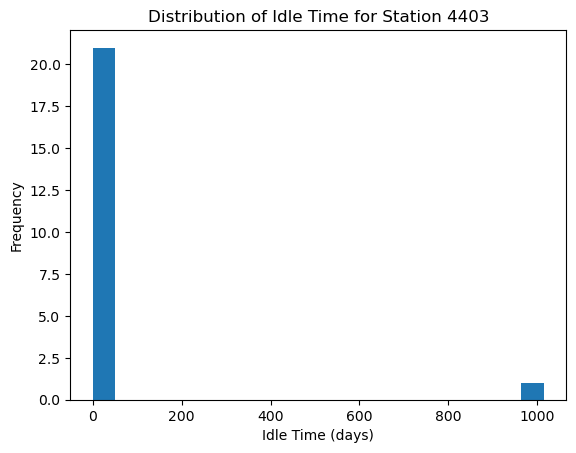

In [33]:
# Filter the rows for the station with ID 4403
station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]

# Convert the idle_time column to numeric values in days
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)

# Create a histogram of idle_time values
plt.hist(station_data['idle_time'], bins=20)
plt.xlabel('Idle Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Idle Time for Station 4403')
plt.show()


Looking at the Histogramm we can see that we have around 40 rows that has more than 1000 days in idle time.
It seems tht there has been a huge break in the usage in this station, let try to find it.

In [34]:
station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]
station_data['start_time'] = pd.to_datetime(station_data["start_time"])
station_data['end_time'] = pd.to_datetime(station_data["end_time"])

# Convert 'idle_time' column to Timedelta
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time'])
# Filter the rows for the station with ID 4403 and idle_time over 1000 days
long_idle_trips = station_data[station_data["idle_time"] > pd.Timedelta(days=1000)]
# Sort the trips by end_time in ascending order
long_idle_trips = long_idle_trips.sort_values('end_time')

# Initialize an empty DataFrame to store the comparison results
comparison_results = pd.DataFrame(columns=['Trip', 'End Time', 'Next Start Time'])

# Iterate over the rows of the long_idle_trips DataFrame
for index, row in long_idle_trips.iterrows():
    end_time = row['end_time']
    for index, row in station_data.iterrows():
        if row["start_time"] > end_time:
            next_start_time = row["start_time"]
    comparison_results = pd.concat([comparison_results, pd.DataFrame({'Trip': [index], 'End Time': [end_time], 'Next Start Time': [next_start_time]})], ignore_index=True)

# Print the comparison results
print(comparison_results)


      Trip            End Time     Next Start Time
0  1532899 2022-12-04 09:21:00 2022-12-04 14:54:00


/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/4193587343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['start_time'] = pd.to_datetime(station_data["start_time"])
/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/4193587343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['end_time'] = pd.to_datetime(station_data["end_time"])
/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/4193587343.py:6: SettingWithCopyWarning: 
A value i

Looking at the data we can see that no one used the station between 2020-02-23 15:09:00 and 2022-12-04 14:54:00

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/4258551898.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_40_stations["end_station_id"] = top_40_stations["end_station_id"].astype(str)


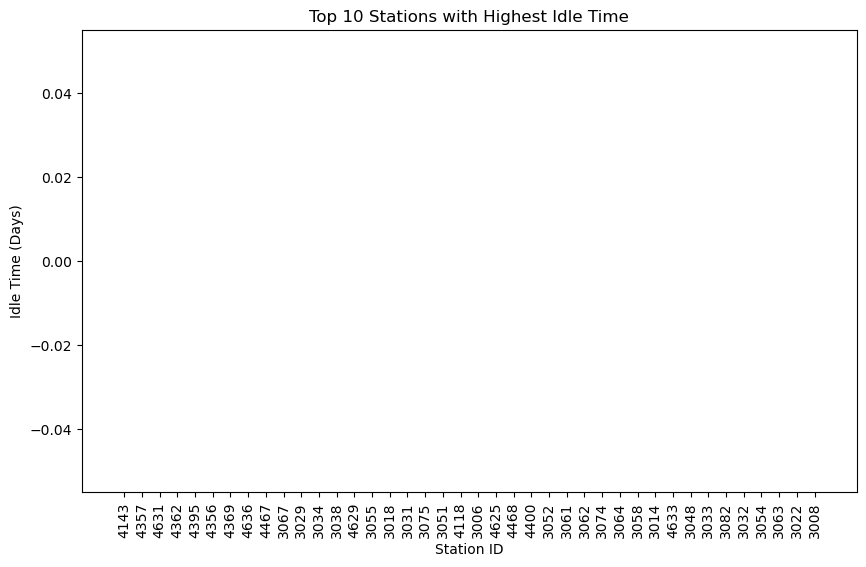

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 82 to 399
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   end_station_id   400 non-null    int64          
 1   idle_time        400 non-null    timedelta64[ns]
 2   morgens          400 non-null    int64          
 3   vormittags       400 non-null    int64          
 4   mittags          400 non-null    int64          
 5   nachmittags      400 non-null    int64          
 6   abends           400 non-null    int64          
 7   nachts           400 non-null    int64          
 8   monday           400 non-null    int64          
 9   tuesday          400 non-null    int64          
 10  wednesday        400 non-null    int64          
 11  thursday         400 non-null    int64          
 12  friday           400 non-null    int64          
 13  saturday         400 non-null    int64          
 14  sunday           400 non-

In [61]:
sorted_df['end_station_lat'] = sorted_df['end_station_lat'].str[1:-1].astype(np.float64)
sorted_df['end_station_lon'] = sorted_df['end_station_lon'].str[1:-1].astype(np.float64)


import matplotlib.pyplot as plt

# Filter the sorted_df to exclude outliers with more than 30 days of idle time
filtered_df = sorted_df[sorted_df['idle_time'] <= pd.Timedelta(days=350)]

# Take the top 10 stations with the highest idle time
top_40_stations = filtered_df.head(40)

# Convert the end_station_id to string
top_40_stations["end_station_id"] = top_40_stations["end_station_id"].astype(str)

# Plot the vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_40_stations["end_station_id"], top_40_stations["idle_time"].dt.days)

# Set the chart title and axis labels
plt.title("Top 10 Stations with Highest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Days)")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.show()
sorted_df.info()


/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/4144703803.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_40_stations["end_station_id"] = top_40_stations["end_station_id"].astype(str)


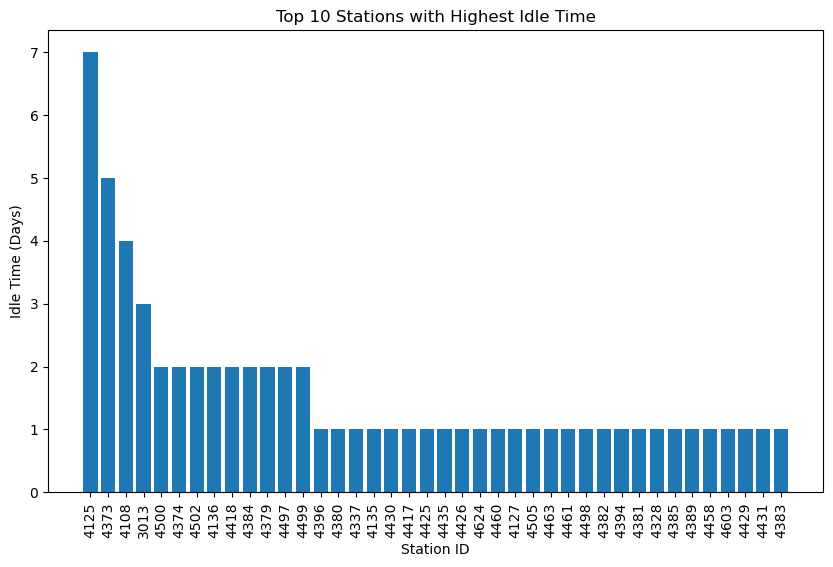

In [36]:
import matplotlib.pyplot as plt

# Filter the sorted_df to exclude outliers with more than 30 days of idle time
filtered_df = sorted_df[sorted_df['idle_time'] <= pd.Timedelta(days=30)]

# Take the top 10 stations with the highest idle time
top_40_stations = filtered_df.head(40)

# Convert the end_station_id to string
top_40_stations["end_station_id"] = top_40_stations["end_station_id"].astype(str)

# Plot the vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_40_stations["end_station_id"], top_40_stations["idle_time"].dt.days)

# Set the chart title and axis labels
plt.title("Top 10 Stations with Highest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Days)")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.show()


We check for each of the 40 stations if they don't have stations nearby by drawing a circle with fixed radius and see how nany stations are in the circle. If we have less than a fixed number of stations in the circle, then this station with high idle time will stay there.

In [37]:
# top_40_stations['end_station_lat'] = top_40_stations['end_station_lat'].str[1:-1].astype(np.float64)
# top_40_stations['end_station_lon'] = top_40_stations['end_station_lon'].str[1:-1].astype(np.float64)
top_40_stations["idle_time"] = pd.to_timedelta(top_40_stations["idle_time"]).dt.total_seconds()/60/60
sorted_df["idle_time"] = pd.to_timedelta(sorted_df["idle_time"]).dt.total_seconds()/60/60


/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/3588650873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_40_stations["idle_time"] = pd.to_timedelta(top_40_stations["idle_time"]).dt.total_seconds()/60/60


In [38]:
print (list(top_40_stations["end_station_id"]))

['4125', '4373', '4108', '3013', '4500', '4374', '4502', '4136', '4418', '4384', '4379', '4497', '4499', '4396', '4380', '4337', '4135', '4430', '4417', '4425', '4435', '4426', '4624', '4460', '4127', '4505', '4463', '4461', '4498', '4382', '4394', '4381', '4328', '4385', '4389', '4458', '4603', '4429', '4431', '4383']


In [39]:
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 399 to 82
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   end_station_id   400 non-null    int64  
 1   idle_time        400 non-null    float64
 2   morgens          400 non-null    int64  
 3   vormittags       400 non-null    int64  
 4   mittags          400 non-null    int64  
 5   nachmittags      400 non-null    int64  
 6   abends           400 non-null    int64  
 7   nachts           400 non-null    int64  
 8   monday           400 non-null    int64  
 9   tuesday          400 non-null    int64  
 10  wednesday        400 non-null    int64  
 11  thursday         400 non-null    int64  
 12  friday           400 non-null    int64  
 13  saturday         400 non-null    int64  
 14  sunday           400 non-null    int64  
 15  end_station_lat  400 non-null    float64
 16  end_station_lon  400 non-null    float64
dtypes: float64(3), 

In [40]:
nodups_df = sorted_df.drop_duplicates(subset=["end_station_lon", "end_station_lat"], keep = "first")
print(sorted_df.info(), nodups_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 399 to 82
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   end_station_id   400 non-null    int64  
 1   idle_time        400 non-null    float64
 2   morgens          400 non-null    int64  
 3   vormittags       400 non-null    int64  
 4   mittags          400 non-null    int64  
 5   nachmittags      400 non-null    int64  
 6   abends           400 non-null    int64  
 7   nachts           400 non-null    int64  
 8   monday           400 non-null    int64  
 9   tuesday          400 non-null    int64  
 10  wednesday        400 non-null    int64  
 11  thursday         400 non-null    int64  
 12  friday           400 non-null    int64  
 13  saturday         400 non-null    int64  
 14  sunday           400 non-null    int64  
 15  end_station_lat  400 non-null    float64
 16  end_station_lon  400 non-null    float64
dtypes: float64(3), 

In [41]:
import folium
import pandas as pd
from folium import plugins
from folium.plugins import HeatMap

### Remove stations out of sorted_df where lon/lat are duplicate.
# Latitude and Longitude coordinates of Los Angeles
la_coordinates = (34.0522, -118.2437)

# Create a folium map centered on Los Angeles
map_la = folium.Map(location=la_coordinates, zoom_start=11)

# Iterate over the rows of the DataFrame
heatlist = []
for index, row in nodups_df.iterrows():
    station_id = row['end_station_id'].astype("int")
    lat = float(row['end_station_lat'])
    lon = float(row['end_station_lon'])
    idle = float(row["idle_time"])

    heatlist.append([lat, lon, np.sqrt(idle)])
    if str(station_id) in list(top_40_stations["end_station_id"]):
        # Add a marker for each station to the map
        folium.Circle(location=[lat, lon], tooltip=[str(station_id), idle], radius = 500).add_to(map_la)
        folium.Marker(location=[lat, lon], tooltip=[str(station_id), idle], icon = folium.Icon(color="red")).add_to(map_la)
    else:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id), idle]).add_to(map_la)

#Add a Heatmap
# HeatMap(data= heatlist).add_to(map_la)
# Display the map
map_la

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/923204609.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_10_stations["end_station_id"] = bottom_10_stations["end_station_id"].astype(str)


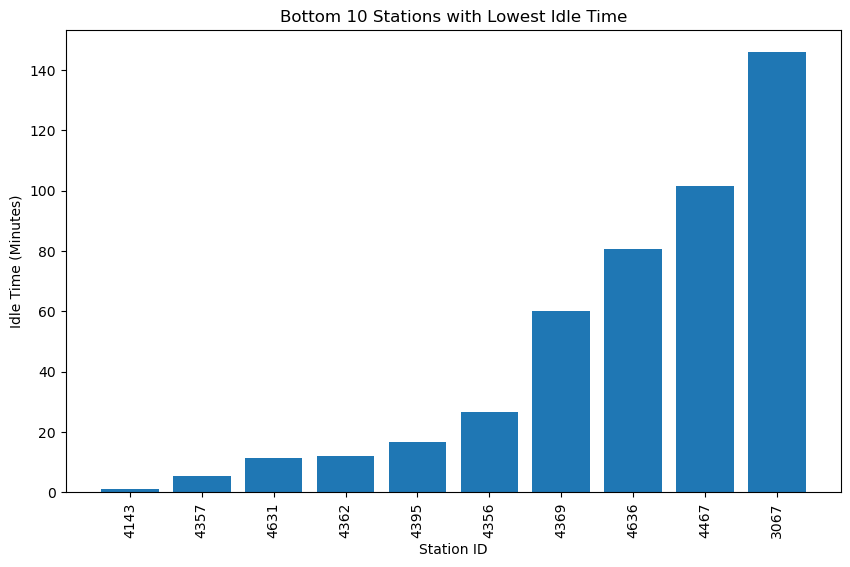

In [42]:
import matplotlib.pyplot as plt

# Sort the dataframe by idle_time in ascending order
df["idle_time"] = pd.to_timedelta(df["idle_time"])
sorted_df = df.sort_values(by="idle_time")

# Filter out outliers with more than 30 days of idle time
filtered_df = sorted_df[sorted_df["idle_time"] <= pd.Timedelta(days=30)]

# Select the bottom 10 stations with the lowest idle time
bottom_10_stations = filtered_df.head(10)

# Convert the end_station_id to string
bottom_10_stations["end_station_id"] = bottom_10_stations["end_station_id"].astype(str)

# Plot the vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(bottom_10_stations["end_station_id"], bottom_10_stations["idle_time"].dt.total_seconds()/60)

# Set the chart title and axis labels
plt.title("Bottom 10 Stations with Lowest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Minutes)")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.show()


In [63]:
import matplotlib.pyplot as plt

df = pd.read_csv(csv_file)

# Sort the dataframe by idle_time in ascending order
df["idle_time"] = pd.to_timedelta(df["idle_time"])

sorted_df_idletime = df.sort_values(by="idle_time", ascending=False)
no_outlier_df = sorted_df_idletime[sorted_df_idletime["idle_time"] <= pd.Timedelta(days=30)]
top_50_percent = no_outlier_df.head(197)
no_outlier_df.info(),df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 69 to 82
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   end_station_id   398 non-null    int64          
 1   idle_time        398 non-null    timedelta64[ns]
 2   morgens          398 non-null    int64          
 3   vormittags       398 non-null    int64          
 4   mittags          398 non-null    int64          
 5   nachmittags      398 non-null    int64          
 6   abends           398 non-null    int64          
 7   nachts           398 non-null    int64          
 8   monday           398 non-null    int64          
 9   tuesday          398 non-null    int64          
 10  wednesday        398 non-null    int64          
 11  thursday         398 non-null    int64          
 12  friday           398 non-null    int64          
 13  saturday         398 non-null    int64          
 14  sunday           398 non-n

(None, None)

In [43]:

avg_idle_time_top_50 = top_50_percent["idle_time"].mean()
# print(avg_idle_time_top_50)

bottom_50_percent = sorted_df_idletime.tail(197)
avg_idle_time_bottom_50 = bottom_50_percent["idle_time"].mean()

# print(avg_idle_time_bottom_50)


over_top_avg_df = sorted_df_idletime[sorted_df_idletime["idle_time"] >= avg_idle_time_top_50]
# over_top_avg_df.count()

under_bottom_avg_df = sorted_df_idletime[sorted_df["idle_time"] <= avg_idle_time_bottom_50]
# under_bottom_avg_df.info()

over_top_avg_df["end_station_lat"] = over_top_avg_df['end_station_lat'].str[1:-1].astype(np.float64)
over_top_avg_df["end_station_lon"] = over_top_avg_df['end_station_lon'].str[1:-1].astype(np.float64)

under_bottom_avg_df["end_station_lat"] = under_bottom_avg_df['end_station_lat'].str[1:-1].astype(np.float64)
under_bottom_avg_df["end_station_lon"] = under_bottom_avg_df['end_station_lon'].str[1:-1].astype(np.float64)

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/3984960953.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  under_bottom_avg_df = sorted_df_idletime[sorted_df["idle_time"] <= avg_idle_time_bottom_50]
/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/3984960953.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_top_avg_df["end_station_lat"] = over_top_avg_df['end_station_lat'].str[1:-1].astype(np.float64)
/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/3984960953.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [44]:
sorted_df_idletime.info()
sorted_df_idletime["end_station_lat"] = sorted_df_idletime['end_station_lat'].str[1:-1].astype(np.float64)
sorted_df_idletime["end_station_lon"] = sorted_df_idletime['end_station_lon'].str[1:-1].astype(np.float64)
sorted_df_idletime["idle_time"] = sorted_df_idletime["idle_time"].dt.total_seconds()/60/60


<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 399 to 82
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   end_station_id   400 non-null    int64          
 1   idle_time        400 non-null    timedelta64[ns]
 2   morgens          400 non-null    int64          
 3   vormittags       400 non-null    int64          
 4   mittags          400 non-null    int64          
 5   nachmittags      400 non-null    int64          
 6   abends           400 non-null    int64          
 7   nachts           400 non-null    int64          
 8   monday           400 non-null    int64          
 9   tuesday          400 non-null    int64          
 10  wednesday        400 non-null    int64          
 11  thursday         400 non-null    int64          
 12  friday           400 non-null    int64          
 13  saturday         400 non-null    int64          
 14  sunday           400 non-

In [45]:
print(list(top_50_percent["end_station_id"]))

[4125, 4373, 4108, 3013, 4500, 4374, 4502, 4136, 4418, 4384, 4379, 4497, 4499, 4396, 4380, 4337, 4135, 4430, 4417, 4425, 4435, 4426, 4624, 4460, 4127, 4505, 4463, 4461, 4498, 4382, 4394, 4381, 4328, 4385, 4389, 4458, 4603, 4429, 4431, 4383, 4134, 4428, 4336, 4416, 4397, 4419, 4605, 4541, 4422, 4427, 4597, 4484, 4408, 4415, 3039, 4213, 4378, 4432, 4133, 4329, 4331, 4459, 4595, 4341, 4372, 4604, 4322, 4470, 4462, 4333, 4332, 4420, 4393, 4323, 4338, 4606, 4596, 4451, 4354, 4132, 4350, 4335, 4559, 4600, 4131, 4414, 4580, 4602, 4340, 4205, 4469, 4598, 4503, 4130, 4413, 4452, 4324, 4301, 4542, 4129, 4436, 4614, 4601, 4560, 4438, 4577, 4321, 4352, 4526, 4478, 4582, 4409, 4439, 4579, 4521, 4303, 4208, 4472, 4599, 4325, 4474, 4334, 4457, 4349, 4437, 4330, 4549, 4351, 4453, 4556, 4504, 4552, 4285, 4146, 4348, 4126, 4613, 4573, 4593, 4513, 4571, 4342, 4343, 4583, 4554, 4442, 4406, 4594, 4509, 4455, 4510, 4483, 4527, 4534, 4353, 4441, 4286, 4207, 4529, 4346, 4245, 4347, 4476, 4561, 4152, 4496, 449

In [46]:
import folium
import pandas as pd
from folium import plugins
from folium.plugins import HeatMap

# Latitude and Longitude coordinates of Los Angeles
la_coordinates = (34.0522, -118.2437)

# Create a folium map centered on Los Angeles
map_la = folium.Map(location=la_coordinates, zoom_start=11)
count = 0
# Iterate over the rows of the DataFrame
heatlist = []
for index, row in sorted_df_idletime.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    idle = float(row["idle_time"])

    if station_id in list(over_top_avg_df["end_station_id"]):
        # Add a marker for each station to the map
        folium.Circle(location=[lat, lon], tooltip=[str(station_id), idle], radius = 500).add_to(map_la)
        folium.Marker(location=[lat, lon], tooltip=[str(station_id), idle], icon = folium.Icon(color="red")).add_to(map_la)
    else:
       folium.Marker(location=[lat, lon], tooltip=[str(station_id), idle]).add_to(map_la)

#Add a Heatmap
# HeatMap(data= heatlist).add_to(map_la)
# Display the map
map_la

In [47]:
import folium
import pandas as pd
from folium import plugins
from folium.plugins import HeatMap

# Latitude and Longitude coordinates of Los Angeles
la_coordinates = (34.0522, -118.2437)

# Create a folium map centered on Los Angeles
map_la = folium.Map(location=la_coordinates, zoom_start=11)
count = 0
# Iterate over the rows of the DataFrame
heatlist = []
for index, row in sorted_df_idletime.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    idle = float(row["idle_time"])

    if station_id in list(under_bottom_avg_df["end_station_id"]):
        # Add a marker for each station to the map
        folium.Circle(location=[lat, lon], tooltip=[str(station_id), idle], radius = 500).add_to(map_la)
        folium.Marker(location=[lat, lon], tooltip=[str(station_id), idle], icon = folium.Icon(color="red")).add_to(map_la)
    else:
       folium.Marker(location=[lat, lon], tooltip=[str(station_id), idle]).add_to(map_la)

#Add a Heatmap
# HeatMap(data= heatlist).add_to(map_la)
# Display the map
map_la

In [48]:
from geopy import distance

over_top_avg_df["neighboring_stations"] = None
over_top_avg_df["avg_neighbor_idle_time"] = None
for i, row in over_top_avg_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    center_coords = (lat, lon)
    neighbor_idle_time_sum = pd.Timedelta(0)


    neighboring_stations = []
    for index, sorted_row in sorted_df_idletime.iterrows():
        station_coords = (sorted_row['end_station_lat'], sorted_row['end_station_lon'])
        dist = distance.distance(center_coords, station_coords).meters
        
        if dist <= 500:
            neighboring_stations.append(sorted_row["end_station_id"])
            neighbor_idle_time_sum += pd.Timedelta(sorted_row["idle_time"])
    over_top_avg_df.at[i, "neighboring_stations"] = neighboring_stations
    over_top_avg_df.at[i, "avg_neighbor_idle_time"] = neighbor_idle_time_sum / len(neighboring_stations)


under_bottom_avg_df["neighboring_stations"] = None
under_bottom_avg_df["avg_neighbor_idle_time"] = None

for i, row in under_bottom_avg_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    center_coords = (lat, lon)
    neighbor_idle_time_sum = pd.Timedelta(0)


    neighboring_stations = []
    for index, sorted_row in sorted_df_idletime.iterrows():
        station_coords = (sorted_row['end_station_lat'], sorted_row['end_station_lon'])
        dist = distance.distance(center_coords, station_coords).meters
        
        if dist <= 500:
            neighboring_stations.append(sorted_row["end_station_id"])
            neighbor_idle_time_sum += pd.Timedelta(sorted_row["idle_time"])


    under_bottom_avg_df.at[i, "neighboring_stations"] = neighboring_stations
    under_bottom_avg_df.at[i, "avg_neighbor_idle_time"] = neighbor_idle_time_sum / len(neighboring_stations)
over_top_avg_df.set_index('end_station_id')
sorted_df.to_csv('sorted.csv')
over_top_avg_df.head()

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/2419661738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_top_avg_df["neighboring_stations"] = None
/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/2419661738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_top_avg_df["avg_neighbor_idle_time"] = None
/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/2419661738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

FileNotFoundError: [Errno 2] No such file or directory: 'sorted.csv'

In [ ]:
# Convert idle_time in df_sorted from string to timedelta
sorted_df['idle_time'] = pd.to_timedelta(sorted_df['idle_time'])

def calculate_avg_neighbor_idle_time_gpt(row):
    # Get the idle times of the neighboring stations from df_sorted
    neighbor_idle_times = sorted_df.loc[sorted_df['end_station_id'].isin(row['neighboring_stations']), 'idle_time']

    # Calculate and return the average idle time
    return neighbor_idle_times.mean()

over_top_avg_df['avg_neighbor_idle_time'] = over_top_avg_df.apply(calculate_avg_neighbor_idle_time_gpt, axis=1)
under_bottom_avg_df['avg_neighbor_idle_time'] = under_bottom_avg_df.apply(calculate_avg_neighbor_idle_time_gpt, axis=1)

over_top_avg_df.head(), under_bottom_avg_df.head()

In [55]:
count = over_top_avg_df["neighboring_stations"].apply(lambda x : len(x) > 2)
over_top_avg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 399 to 195
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   end_station_id          67 non-null     int64          
 1   idle_time               67 non-null     timedelta64[ns]
 2   morgens                 67 non-null     int64          
 3   vormittags              67 non-null     int64          
 4   mittags                 67 non-null     int64          
 5   nachmittags             67 non-null     int64          
 6   abends                  67 non-null     int64          
 7   nachts                  67 non-null     int64          
 8   monday                  67 non-null     int64          
 9   tuesday                 67 non-null     int64          
 10  wednesday               67 non-null     int64          
 11  thursday                67 non-null     int64          
 12  friday                  67 non-null

In [56]:
count2 = under_bottom_avg_df["neighboring_stations"].apply(lambda x : len(x) > 2)
count2.sum(), under_bottom_avg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 154 to 82
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   end_station_id          94 non-null     int64          
 1   idle_time               94 non-null     timedelta64[ns]
 2   morgens                 94 non-null     int64          
 3   vormittags              94 non-null     int64          
 4   mittags                 94 non-null     int64          
 5   nachmittags             94 non-null     int64          
 6   abends                  94 non-null     int64          
 7   nachts                  94 non-null     int64          
 8   monday                  94 non-null     int64          
 9   tuesday                 94 non-null     int64          
 10  wednesday               94 non-null     int64          
 11  thursday                94 non-null     int64          
 12  friday                  94 non-null 

(71, None)

In [57]:
for i, row in over_top_avg_df.iterrows():
    neighboring_stations = row["neighboring_stations"]
    print(type(neighboring_stations))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

/var/folders/_v/6rn4knv13fs88z1_74ms8bk40000gn/T/ipykernel_33270/3022689098.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_10_stations["end_station_id"] = bottom_10_stations["end_station_id"].astype(str)


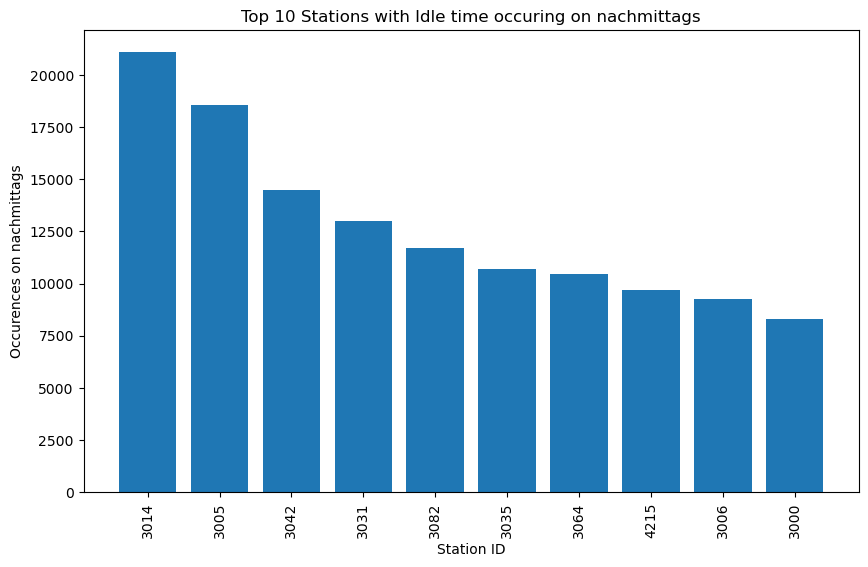

In [58]:
import matplotlib.pyplot as plt

df = pd.read_csv(csv_file)

# Sort the dataframe by idle_time in ascending order
df["idle_time"] = pd.to_timedelta(df["idle_time"])
sorted_df_tuesday = df.sort_values(by="nachmittags", ascending=False)
# Select the bottom 10 stations with the lowest idle time
bottom_10_stations = sorted_df_tuesday.head(10)

# Convert the end_station_id to string
bottom_10_stations["end_station_id"] = bottom_10_stations["end_station_id"].astype(str)

# Plot the vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(bottom_10_stations["end_station_id"], bottom_10_stations["nachmittags"])

# Set the chart title and axis labels
plt.title("Top 10 Stations with Idle time occuring on nachmittags")
plt.xlabel("Station ID")
plt.ylabel("Occurences on nachmittags")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.show()


#### Geographical Data Visalization
In this section, we will further visualize the exact coordinates of the bike stations on a Los Angeles map and therefore enable the marketing section to further analize how location of the stations may be connected to its idle time, e.g. its productiveness.
As we only need the geographical data of each station, and its ID and idle time, we can create a new DataFrame and leave out the rest of the information.


In [59]:
df = pd.read_csv("../Data_Cleanup/outCSV/Station_ID_with_AvgIdleDaytimesDays_and_lonlat.csv")
df = df.drop(df.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1)
df['end_station_lat'] = df['end_station_lat'].str[1:-1].astype(np.float64)
df['end_station_lon'] = df['end_station_lon'].str[1:-1].astype(np.float64)
df["idle_time"] = pd.to_timedelta(df["idle_time"]).dt.total_seconds()/60/60

#df['location'] = df.apply(lambda row: row['end_station_lon'] + row['end_station_lat'], axis=1)
df.head()

,end_station_id,idle_time,end_station_lat,end_station_lon
0,3000,9.934171,34.048500,-118.258537
1,3005,3.947014,34.048500,-118.258537
2,3006,3.161311,34.045540,-118.256668
3,3007,4.588129,34.050480,-118.254593
4,3008,3.886666,34.046612,-118.262733


In [60]:
# Latitude and Longitude coordinates of Los Angeles
la_coordinates = (34.0522, -118.2437)

# Create a folium map centered on Los Angeles
map_la = folium.Map(location=la_coordinates, zoom_start=11)

# Iterate over the rows of the DataFrame
heatlist = []
for index, row in df.iterrows():
    station_id = row['end_station_id']
    lat = float(row['end_station_lat'])
    lon = float(row['end_station_lon'])
    idle = float(row["idle_time"])
    heatlist.append([lat, lon, np.sqrt(idle)])

    # Add a marker for each station to the map
    folium.CircleMarker(location=[lat, lon], tooltip=str(station_id), radius = np.sqrt(idle*2)).add_to(map_la)

#Add a Heatmap
HeatMap(data= heatlist).add_to(map_la)
# Display the map
map_la

To consider a station as good performing: 